# Lab-based Group Assignment 4:
## Prediction of Product Satisfaction by using Customer Reviews

![Imgur](https://i.imgur.com/4HJknC2.png)

### Business Problem
For companies, it is very important to quantify customers' satisfaction on your products so that customer retention team could intervene with corresponding measures before the customers churn due to dissatisfaction (e.g. provide refund for customers who have very low satisfaction on your product, while only provide replacement for customers who have relatively low satisfaction).  
  
Such kind of quantification is very easy to do on e-commerce websites since customers who write reviews for products would also providing a rating for the product. However, for customers who shop offline and for those who discuss about the products through other online channels such as Twitter and blogs, such kind of quantification doesn't exist, which hinders the ability of a company to retain these customers.  
  
Therefore, it is crucial for a company to create a satisfaction rating prediction model based on customers' discussion.  

![Imgur](https://i.imgur.com/O1XLXaS.png)

Credit: Amazon Seller Center

### Task
For this assignment, you are required to create a rating prediction model based on customers' reviews about women's clothing on an e-commerce platform.

### File Preparation:

Read the data into a dataframe. **Reviews with no rating and ratings with no review text should be excluded from the dataframe.**

TIPS:The columns you would use are the rating column and review text column

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl

In [3]:
import keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_excel('/content/drive/MyDrive/Deep Learning/E-Commerce Reviews Dataset.xlsx',index_col=0)

In [4]:
df=df.loc[:,["Review Text","Rating"]].dropna().reset_index(drop=True) #select txt content (input) and rating (output) from the dataframe

After cleaning the data, you should have 22641 reviews available.

In [5]:
len(df)

22641

In [6]:
df["Rating"].value_counts() #1,2,3,4,5 are values of multiclass output. You can see the count number for each class.

,count
Rating,
5,12540
4,4908
3,2823
2,1549
1,821


**Comment:**  
The distribution of the rating is uneven. Nearly 55% of the reviews have a 5-star rating. Therefore, in order to ensure each subgroup within the population receives proper representation within the sample, we need to do a stratified sampling.  

(Two other methods are to give more weights on less reprsented ratings or to give less weight on more represented ratings. This is an advanced sampling technique that is very useful when training on contingencies such as credit fraud)

### **Question 1:** Please change your test size 0.1, 0.2, 0.3 for getting lower mape errors for training and validation results, and explain what you have after changing these parameters. Note: You can change these values and run your model again and again...

Build a train dataset for model training and validation dataset for model assessment.  
90% of the data should be used to build the training subset, while 10% of the data should be used to build the validation subset.  
You should use review text as the predictor and rating as the outcome.  

In [7]:
from sklearn.model_selection import train_test_split
rev=df["Review Text"]
target=df["Rating"]
x_train, x_test, y_train, y_test = train_test_split(rev,target,test_size=0.1,random_state=0,stratify=target) #split the dataset to train, validation and test. Like we did before.

Provide a common-sense, non-machine learning baseline prediction

**TIPS:**  
**Treat rating as a continuous variable for this assignment.**  
Although technically, the rating is a categorical variable (you can only choose between 1,2,3,4, and 5). In this scenario, it is possible to treat it as a continuous variable when doing prediction.  
For example, a rating of 3.7 generated by the prediction model indicates that the customer has a satisfaction level of around 3-4, with an inclination towards 4.   

In [8]:
average_rating=y_test.mean()
mae=0
for rating in y_test:
  mae+=abs(rating-average_rating)
print(mae/len(y_test))

0.9041474789117512


**Comment:**  
Always predict that the rating is the average rating of the test dataset rating. In this case, the mean absolute percent error is about 0.9.  

(Other metrics include MSE, MAPE, etc)  

### **Question 2:** For preparing your word embeding vectors, please change maxlen as 10, 100, and 150 for getting better mape errors for training and validation results, and explain what you have after changing these parameters.

#### Please use word embedding and interpret what is the max_features and maxlen

Tips: Use Tokenizer (use pad sequences instead of one-hot encoding)

In [14]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Number of words to consider as features
max_features = 10000
maxlen = 100 #Maximum sequence length
batch_size = 32 #the number of rows of input for each step

#Tokenizing
tokenizer = Tokenizer(max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)#Those 4 rows transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from 1 - max_features

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')


print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen) #make sure that the length of every array reaches maxlen by filling zeros in front of all arrays. Not all text contents have the maxlen we set in original dataset.
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

20376 train sequences
2265 test sequences
Pad sequences (samples x text length)
X_train shape: (20376, 100)
X_test shape: (2265, 100)


### **Question 3:** Please use SimpleRNN, LSTM, droupout, recurrent_dropout, and change other parameters for getiing better mape results, and explain what you have after changing these parameters.

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
embedding_dim = 64
max_features = 10000
maxlen = 100
#input_dim, output_dim, input_lenght
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
# After the Embedding layer,
# our activations have shape `(samples, maxlen, 64)`.
# when embedding connects to RNN or LSTM layers, flatten() is not needed.
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(16)) # default activation is "tanh"
model.add(Dense(1)) #this means we have only 1 number (1,2,3,4,5) to represent output rating.
model.predict(X_train[:1])
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (1, 100, 64)                │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (1, 100, 32)                │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (1, 16)                     │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,161 (2.49 MB)

 Trainable params: 652,161 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - loss: 6.5546 - mape: 51.4449 - val_loss: 1.2410 - val_mape: 33.9609
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 1.2382 - mape: 33.8356 - val_loss: 1.2318 - val_mape: 34.0818
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 1.2258 - mape: 33.9163 - val_loss: 1.1632 - val_mape: 32.5769
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 1.1326 - mape: 31.9435 - val_loss: 1.1296 - val_mape: 27.5569
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - loss: 0.8649 - mape: 26.0082 - val_loss: 0.7805 - val_mape: 24.6618
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.7216 - mape: 23.1348 - val_loss: 0.7959 - val_mape: 24.9650
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step - loss: 0.5628 - mape: 19.7246 - val_loss: 0.8151 - val_mape: 24.9776
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - loss: 0.5090 - mape: 18.7441 - val_loss: 0.7768 - val_mape: 22.6659
Epoch 9/

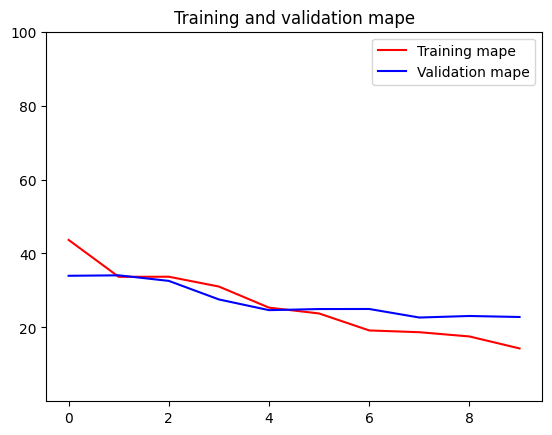

In [30]:
#You can just use the codes below to plot
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

Please interpret your results.

*Comment*:  The model is having overfitting problem.

### **Question 4**: Please combine embedding and CNN in one model

Rubric: Use Tokenizer, use Conv1D, dropout and stacking are optional

In [21]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 64, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu')) #Note, we use Conv1d here instead of Conv2d in Lab 3. Thats because the input shape changes. (decrease)
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.predict(X_train[:1])
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (1, 96, 128)                │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (1, 32, 128)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (1, 28, 128)                │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (1, 128)                    │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 763,265 (2.91 MB)

 Trainable params: 763,265 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='mse', metrics=['mape']) #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 2.8667 - mape: 38.6568 - val_loss: 0.8240 - val_mape: 25.5395
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.8144 - mape: 25.3414 - val_loss: 0.8374 - val_mape: 26.0139
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.7627 - mape: 23.6806 - val_loss: 0.7560 - val_mape: 24.5218
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.6346 - mape: 21.7724 - val_loss: 0.7422 - val_mape: 23.4193
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.6458 - mape: 22.2348 - val_loss: 0.7066 - val_mape: 23.5240
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.5885 - mape: 20.5502 - val_loss: 0.7339 - val_mape: 22.4551
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 0.4477 - mape: 17.3987 - val_loss: 0.6459 - val_mape: 21.7288
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.4525 - mape: 17.3959 - val_loss: 0.6675 - val_mape: 22.1566
Epoch 9/10

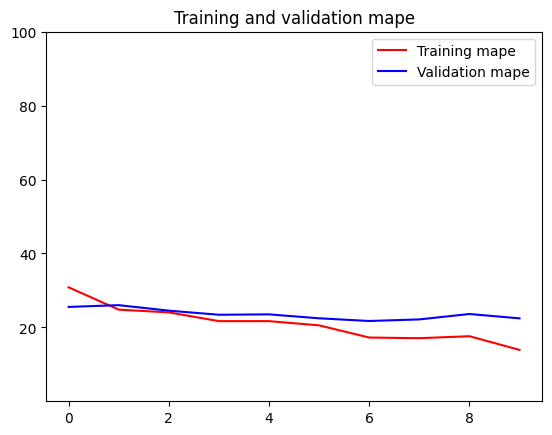

In [26]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

### **Question 5**: Please use the dropout with LSTM and interpret the results.

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()

embedding_dim = 64
maxlen = 100
max_features = 10000

model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.predict(X_train[:1])
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (1, 128)                    │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,945 (2.82 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step - loss: 3.7535 - mape: 43.5076 - val_loss: 1.0743 - val_mape: 30.8562
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 46s 181ms/step - loss: 1.0523 - mape: 29.9714 - val_loss: 0.8328 - val_mape: 24.7427
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - loss: 0.8120 - mape: 24.6818 - val_loss: 0.7033 - val_mape: 23.2907
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 189ms/step - loss: 0.6602 - mape: 22.0006 - val_loss: 0.6103 - val_mape: 21.1213
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 48s 187ms/step - loss: 0.5648 - mape: 19.7395 - val_loss: 0.5853 - val_mape: 20.9334
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - loss: 0.5427 - mape: 19.0923 - val_loss: 0.5807 - val_mape: 19.9852
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 46s 180ms/step - loss: 0.4746 - mape: 17.7302 - val_loss: 0.5592 - val_mape: 20.0458
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 47s 183ms/step - loss: 0.4898 - mape: 18.2737 - val_loss: 0.5494 - val_mape: 18.6829
E

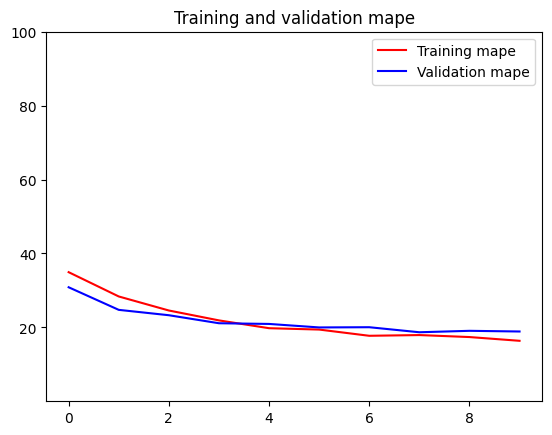

In [34]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

## Q6: Please use regularization with CNN and LSTM   
**Instructions:**  You are required to use dropout when building prediction model in this question.  

In [35]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.LSTM(62,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(1))
model.predict(X_train[:1])
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (1, 96, 128)                │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (1, 62)                     │          47,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 728,519 (2.78 MB)

 Trainable params: 728,519 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - loss: 3.9143 - mape: 43.9790 - val_loss: 0.9089 - val_mape: 27.0349
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.8468 - mape: 25.1748 - val_loss: 0.6874 - val_mape: 22.1322
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.6664 - mape: 21.9674 - val_loss: 0.7174 - val_mape: 22.4273
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - loss: 0.5402 - mape: 19.1255 - val_loss: 0.6189 - val_mape: 20.6866
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - loss: 0.4963 - mape: 18.2061 - val_loss: 0.5498 - val_mape: 19.8311
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.5536 - mape: 19.8265 - val_loss: 0.5282 - val_mape: 19.5465
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - loss: 0.4109 - mape: 16.5758 - val_loss: 0.5387 - val_mape: 18.8749
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - loss: 0.3956 - mape: 15.7891 - val_loss: 0.5632 - val_mape: 19.7189
Ep

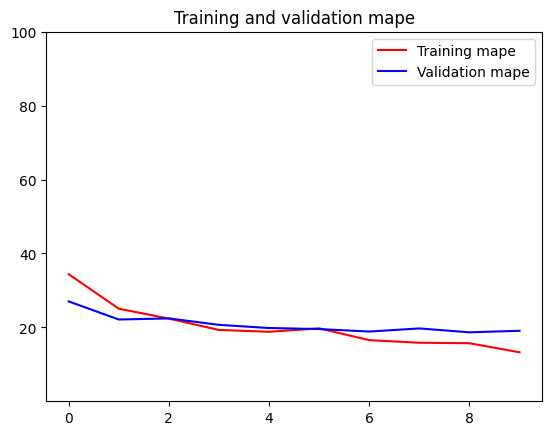

In [37]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

In [39]:
from tensorflow.keras import regularizers
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Bidirectional(
    layers.LSTM(64,dropout=0.2,recurrent_dropout=0.2,kernel_regularizer=regularizers.l2(0.01))))
model.add(layers.Dense(1, kernel_regularizer=regularizers.l2(0.01)))
model.predict(X_train[:1])
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (1, 96, 128)                │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 128)                    │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 780,033 (2.98 MB)

 Trainable params: 780,033 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()

Epoch 1/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 119s 180ms/step - loss: 3.7158 - mape: 35.0791 - val_loss: 1.0092 - val_mape: 23.6369
Epoch 2/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 134s 167ms/step - loss: 0.7988 - mape: 22.2590 - val_loss: 0.7279 - val_mape: 20.8264
Epoch 3/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 146s 174ms/step - loss: 0.6403 - mape: 19.4732 - val_loss: 0.6718 - val_mape: 19.1443
Epoch 4/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 109s 171ms/step - loss: 0.5857 - mape: 18.3943 - val_loss: 0.6717 - val_mape: 20.7136
Epoch 5/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 141s 169ms/step - loss: 0.5528 - mape: 17.7114 - val_loss: 0.7803 - val_mape: 21.6389
Epoch 6/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 142s 169ms/step - loss: 0.5312 - mape: 17.2196 - val_loss: 0.6389 - val_mape: 19.0752
Epoch 7/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 143s 170ms/step - loss: 0.4967 - mape: 16.6312 - val_loss: 0.6523 - val_mape: 20.3936
Epoch 8/10
637/637 ━━━━━━━━━━━━━━━━━━━━ 141s 169ms/step - loss: 0.4745 - mape: 16.2716 - val_loss: 0.6751 - val_mape: 

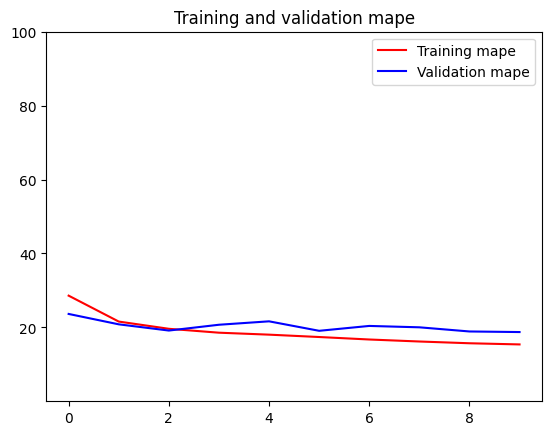

In [41]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

In [42]:
model.save('/content/modelrating.h5')

If you have any questions, please let me know.

Salih Tutun

salihtutun@wustl.edu